In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def plot_model_graph(model):
    """
    Gera o grafo do modelo Bayesiano definido no PyMC.
    
    Parâmetros:
        model (pm.Model): Modelo PyMC definido.
    
    Retorna:
        graphviz.Source: Objeto do grafo do modelo.
    """
    return pm.model_to_graphviz(model)

In [6]:
data = pd.read_csv("../data/JOAO PESSOA.csv")


In [7]:
data

,Data da Coleta,Produto,Valor de Venda
0,2018-12-30,GASOLINA,4.184500
1,2019-01-06,GASOLINA,4.063250
2,2019-01-13,GASOLINA,4.028167
3,2019-01-20,GASOLINA,3.952458
4,2019-01-27,GASOLINA,3.903375
...,...,...,...
309,2024-12-01,GASOLINA,5.861579
310,2024-12-08,GASOLINA,5.853684
311,2024-12-15,GASOLINA,5.841053
312,2024-12-22,GASOLINA,5.846842


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


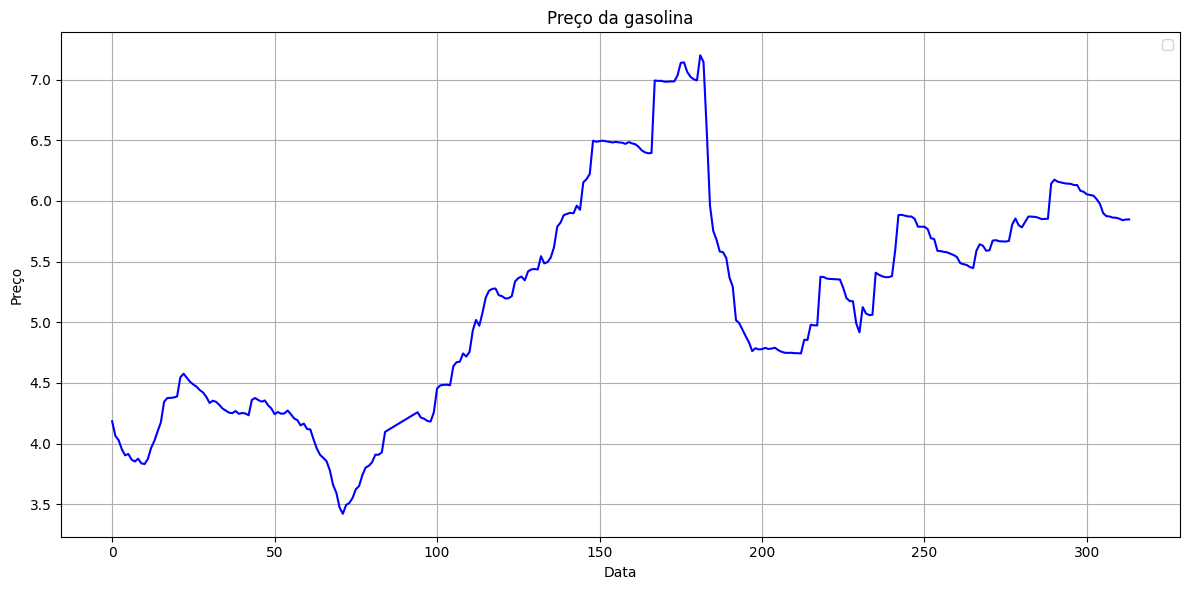

In [8]:

# Renomeando a coluna
data.rename(columns={'Valor de Venda': 'Valor_de_Venda'}, inplace=True)
data = data.drop(columns='Produto')


from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

data['Valor_de_Venda'].interpolate(method='linear', inplace=True)  # Interpola linearmente


# Plotar valores reais e previstos para a cidade
plt.figure(figsize=(12,6))
plt.plot(data['Valor_de_Venda'],  color='blue')

# Títulos e legendas
plt.title('Preço da gasolina')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
data

,Data da Coleta,Valor_de_Venda
0,2018-12-30,4.184500
1,2019-01-06,4.063250
2,2019-01-13,4.028167
3,2019-01-20,3.952458
4,2019-01-27,3.903375
...,...,...
309,2024-12-01,5.861579
310,2024-12-08,5.853684
311,2024-12-15,5.841053
312,2024-12-22,5.846842


In [10]:
# Ordenar por tempo
data = data.sort_values("Data da Coleta")

# Criar variável lag1
data["lag1"] = data["Valor_de_Venda"].shift(1)
data = data.dropna()  # Remover primeira linha com NaN

# Divisão em treino e teste (80% treino, 20% teste)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]



In [11]:
# Definir variáveis para treino
X_train = train_data["lag1"].values
y_train = train_data["Valor_de_Venda"].values

print("tamanho do conjunto de treinamento :",len(X_train))

tamanho do conjunto de treinamento : 250


In [12]:
# Obter os valores do conjunto de teste
X_test = test_data["lag1"].values
y_test = test_data["Valor_de_Venda"].values

print("tamanho do conjunto de teste:",len(X_test))

tamanho do conjunto de teste: 63


In [ ]:
# tentar pegar os parametros com uma regressao

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error
'''
Mudar as mu,sigma em cada distribuição normal
estudar serie pra incluir melhores valores nessas distribuições
medias proximo de zero
'''

coords = {"tempo": train_data["Data da Coleta"].values}  # Coordenadas para PyMC

# Criar modelo Bayesiano com lag no conjunto de treino
with pm.Model(coords=coords) as modelo:
    alpha = pm.Normal("alpha", mu=4, sigma=1)  
    beta = pm.Normal("beta", mu=0, sigma=0.1)  
    sigma = pm.HalfNormal("sigma", sigma=1)  

    mu = alpha + beta * X_train
    precos = pm.Normal("precos", mu=mu, sigma=sigma, observed=y_train, dims="tempo")

    trace = pm.sample(1000, tune=500, target_accept=0.8, random_seed=42)

# Analisar resultados
az.plot_trace(trace, var_names=["alpha", "beta", "sigma"])
az.summary(trace, var_names=["alpha", "beta", "sigma"])

# --------------- Avaliação no Conjunto de Teste ---------------


# Criar previsões para o conjunto de teste
with modelo:
    idata_pred = pm.sample_posterior_predictive(trace, var_names=["alpha", "beta", "sigma"], random_seed=42)

# Obter amostras de alpha e beta do trace
# Obter amostras de alpha e beta do trace
alpha_samples = trace.posterior["alpha"].values  # (chains, draws)
beta_samples = trace.posterior["beta"].values  # (chains, draws)

# Redimensionar para aplicar corretamente aos dados de teste
alpha_samples = alpha_samples.reshape(-1, 1)  # (n_amostras, 1)
beta_samples = beta_samples.reshape(-1, 1)  # (n_amostras, 1)



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


ValueError: Expected 2D array, got 1D array instead:
array=[4.1845     4.06325    4.02816667 3.95245833 3.903375   3.91416667
 3.86720833 3.85245833 3.8755     3.837125   3.83120833 3.87366667
 3.96454167 4.0225     4.10054167 4.1755     4.34541667 4.37533333
 4.37691667 4.37991667 4.38916667 4.546      4.57629167 4.54145833
 4.50891667 4.486625   4.46875    4.4405     4.4205     4.38433333
 4.334375   4.35320833 4.34391667 4.318375   4.288625   4.27195833
 4.25445833 4.25083333 4.268375   4.2456087  4.25195652 4.2483913
 4.23345833 4.35965217 4.37554167 4.3585     4.34545833 4.355125
 4.31570833 4.28968182 4.24275    4.25970833 4.24629167 4.24816667
 4.2726087  4.24191667 4.20754167 4.19320833 4.15029167 4.16470833
 4.12029167 4.116375   4.03379167 3.959125   3.90725    3.88208333
 3.85383333 3.77979167 3.65879167 3.59504167 3.47379167 3.42120833
 3.493625   3.510375   3.55183333 3.62304167 3.650125   3.73858333
 3.801625   3.817      3.84570833 3.90808333 3.90808333 3.92729167
 4.09625    4.11295833 4.12912963 4.14530093 4.16147222 4.17764352
 4.19381481 4.20998611 4.22615741 4.2423287  4.2585     4.214875
 4.20504167 4.186875   4.18141667 4.25575    4.4535     4.48008333
 4.48391667 4.48508333 4.481      4.63720833 4.67104167 4.67420833
 4.74270833 4.717875   4.75559091 4.93216667 5.019125   4.97125
 5.080125   5.20495833 5.26004167 5.27545833 5.27795833 5.222875
 5.215      5.19613043 5.19783333 5.21519048 5.33604167 5.36391667
 5.37608333 5.34554167 5.41891667 5.43570833 5.43875    5.43529167
 5.54441667 5.48533333 5.49575    5.53408333 5.61920833 5.78821739
 5.82133333 5.88320833 5.89316667 5.90195833 5.89825    5.96120833
 5.92716667 6.15295652 6.17975    6.22266667 6.49625    6.487875
 6.49295833 6.497125   6.49125    6.48733333 6.481875   6.48691667
 6.48233333 6.48       6.47041667 6.48541667 6.47458333 6.4675
 6.44666667 6.41708333 6.40041667 6.39333333 6.39458333 6.99291667
 6.98958333 6.99       6.98291667 6.98333333 6.98583333 6.985
 7.03458333 7.13826087 7.14208333 7.06291667 7.02333333 7.0025
 6.99375    7.20083333 7.14625    6.57833333 5.96208333 5.75291667
 5.68125    5.58333333 5.5775     5.53041667 5.36833333 5.29375
 5.01791667 4.99208333 4.93841009 4.88473684 4.83421053 4.76210526
 4.78631579 4.77631579 4.77842105 4.78894737 4.78       4.78315789
 4.79       4.77       4.75684211 4.74894737 4.74736842 4.74875
 4.74526316 4.74473684 4.74315789 4.85578947 4.85368421 4.97894737
 4.97473684 4.97368421 5.37526316 5.37210526 5.36       5.35684211
 5.35578947 5.35368421 5.35210526 5.28368421 5.19894737 5.17473684
 5.17315789 4.99157895 4.91684211 5.125      5.07277778 5.05888889
 5.06166667 5.40842105 5.39105263 5.37888889 5.37166667 5.37166667
 5.38055556 5.59333333 5.88333333 5.88555556 5.87833333 5.87222222
 5.87166667 5.85166667 5.78777778 5.78777778].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
graph = plot_model_graph(modelo)
graph.view()

In [ ]:
# Previsão incremental para cada ponto no tempo
y_pred_incremental = []

for t in range(len(X_test)):
    x_t = X_test[t]  # Apenas o instante t
    
    # Gerar previsão com amostras de alpha e beta
    y_pred_t_samples = alpha_samples + beta_samples * x_t
    
    # Tirar a média das amostras para obter uma única previsão
    y_pred_t = np.mean(y_pred_t_samples)
    
    # Armazena a previsão
    y_pred_incremental.append(y_pred_t)


In [ ]:
# Calcular métricas de desempenho
mae = mean_absolute_error(y_test, y_pred_incremental)
mse = mean_squared_error(y_test, y_pred_incremental)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


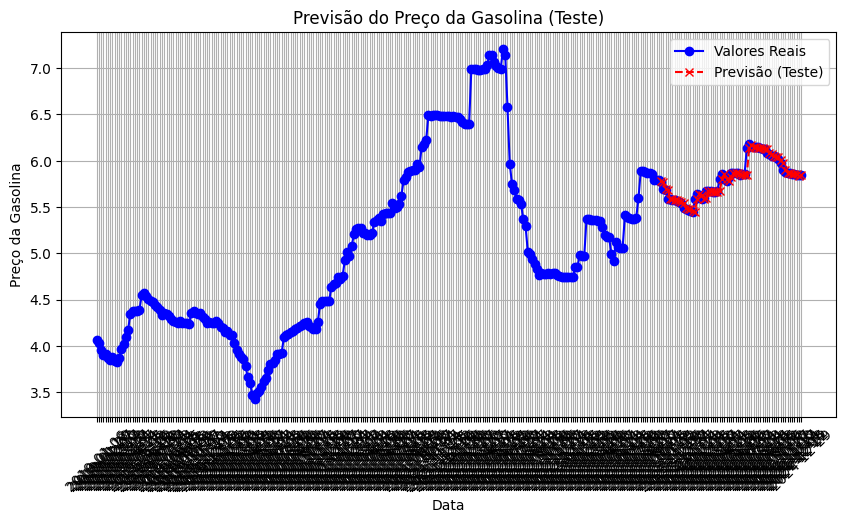

In [ ]:
import matplotlib.pyplot as plt

# Criar figura
plt.figure(figsize=(10, 5))

# Plotar os valores reais
plt.plot(data["Data da Coleta"], data["Valor_de_Venda"], label="Valores Reais", marker="o", color="blue")

# Plotar as previsões APENAS no conjunto de teste
plt.plot(test_data["Data da Coleta"], y_pred, label="Previsão (Teste)", linestyle="--", color="red", marker="x")

# Personalizar gráfico
plt.xlabel("Data")
plt.ylabel("Preço da Gasolina")
plt.title("Previsão do Preço da Gasolina (Teste)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Mostrar gráfico
plt.show()

